Episode 1: Reward = 14.0
Episode 2: Reward = 3.0
Episode 3: Reward = -1.0
Episode 4: Reward = 91.0
Episode 5: Reward = 100.0
Episode 6: Reward = 100.0
Episode 7: Reward = 100.0
Episode 8: Reward = 100.0
Episode 9: Reward = 100.0
Episode 10: Reward = 100.0
Episode 11: Reward = 100.0
Episode 12: Reward = 100.0
Episode 13: Reward = 100.0
Episode 14: Reward = 100.0
Episode 15: Reward = 100.0
Episode 16: Reward = 100.0
Episode 17: Reward = 100.0
Episode 18: Reward = 100.0
Episode 19: Reward = 100.0
Episode 20: Reward = 100.0
Episode 21: Reward = 100.0
Episode 22: Reward = 100.0
Episode 23: Reward = 100.0
Episode 24: Reward = 100.0
Episode 25: Reward = 100.0
Episode 26: Reward = 100.0
Episode 27: Reward = 100.0
Episode 28: Reward = 100.0
Episode 29: Reward = 100.0
Episode 30: Reward = 100.0
Episode 31: Reward = 100.0
Episode 32: Reward = 100.0
Episode 33: Reward = 100.0
Episode 34: Reward = 100.0
Episode 35: Reward = 100.0
Episode 36: Reward = 100.0
Episode 37: Reward = 100.0
Episode 38: Rew

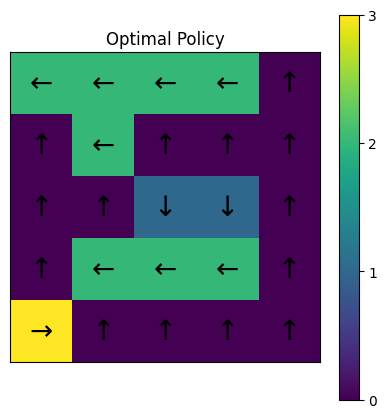

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# グリッドワールドの設定
grid_size = 5
num_actions = 4
num_episodes = 1000
max_steps = 100
learning_rate = 0.1
discount_factor = 0.99

# 行動の定義
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # 上、下、左、右

# 報酬の設定
rewards = np.zeros((grid_size, grid_size))
rewards[0, 0] = 1
rewards[grid_size - 1, grid_size - 1] = -1

# Actor-Criticのパラメータ
actor_weights = np.zeros((grid_size, grid_size, num_actions))
critic_weights = np.zeros((grid_size, grid_size))

# 方策とクリティックの更新
def update_weights(state, action, td_error):
    actor_weights[state[0], state[1], action] += learning_rate * td_error
    critic_weights[state[0], state[1]] += learning_rate * td_error

# 行動の選択
def choose_action(state):
    action_probs = np.exp(actor_weights[state[0], state[1]])
    action_probs /= np.sum(action_probs)
    action = np.random.choice(num_actions, p=action_probs)
    return action

# エピソードの実行
for episode in range(num_episodes):
    state = (0, 0)  # 初期状態
    episode_reward = 0

    for step in range(max_steps):
        action = choose_action(state)
        next_state = tuple(np.array(state) + np.array(actions[action]))
        next_state = np.clip(next_state, 0, grid_size - 1)

        reward = rewards[next_state[0], next_state[1]]
        episode_reward += reward

        # TD誤差の計算
        td_target = reward + discount_factor * critic_weights[next_state[0], next_state[1]]
        td_error = td_target - critic_weights[state[0], state[1]]

        # 重みの更新
        update_weights(state, action, td_error)

        state = tuple(next_state)  # 状態をタプルに変換

        if state == (grid_size - 1, grid_size - 1):
            break

    print(f"Episode {episode + 1}: Reward = {episode_reward}")

# 最適方策の可視化
optimal_policy = np.argmax(actor_weights, axis=2)

plt.figure(figsize=(5, 5))
plt.imshow(optimal_policy, cmap='viridis', interpolation='none')
for i in range(grid_size):
    for j in range(grid_size):
        arrow = '\u2191\u2193\u2190\u2192'[optimal_policy[i, j]]
        plt.text(j, i, arrow, ha='center', va='center', fontsize=20)
plt.colorbar(ticks=[0, 1, 2, 3], orientation='vertical')
plt.xticks([])
plt.yticks([])
plt.title('Optimal Policy')
plt.show()

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# GridWorldの定義
class GridWorld:
    def __init__(self, size=5):
        self.size = size
        self.reset()

    def reset(self):
        self.agent_pos = (0, 0)
        return self.agent_pos

    def step(self, action):
        i, j = self.agent_pos
        if action == 0:  # 上
            i = max(i - 1, 0)
        elif action == 1:  # 右
            j = min(j + 1, self.size - 1)
        elif action == 2:  # 下
            i = min(i + 1, self.size - 1)
        else:  # 左
            j = max(j - 1, 0)

        self.agent_pos = (i, j)
        reward = -1
        done = (i == self.size - 1 and j == self.size - 1)
        return self.agent_pos, reward, done

# Actor-Criticネットワーク
class ActorCritic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc_actor = nn.Linear(hidden_size, output_size)
        self.fc_critic = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        policy = F.softmax(self.fc_actor(x), dim=-1)
        value = self.fc_critic(x)
        return policy, value

# 学習の設定
env = GridWorld()
input_size = 2
hidden_size = 128
output_size = 4
learning_rate = 0.001
num_episodes = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ActorCritic(input_size, hidden_size, output_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 学習ループ
episode_rewards = []

for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0

    while True:
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        policy, value = model(state_tensor)
        action = torch.multinomial(policy, 1).item()

        next_state, reward, done = env.step(action)
        episode_reward += reward

        next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
        _, next_value = model(next_state_tensor)

        advantage = reward + (0 if done else next_value.item()) - value.item()
        actor_loss = -torch.log(policy[0, action]) * advantage
        critic_loss = F.mse_loss(value, torch.tensor([[reward + (0 if done else next_value.item())]], device=device))
        loss = actor_loss + critic_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if done:
            break

        state = next_state

    episode_rewards.append(episode_reward)
    if (episode + 1) % 1 == 0:
        print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward}")

# 結果の可視化
plt.plot(range(1, num_episodes + 1), episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress")
plt.show()

print("Training completed.")

KeyboardInterrupt: 

In [12]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import gym_gridworlds

# グリッドワールドの環境を作成
env = gym.make('Gridworld-v0')

# アクターとクリティックのパラメータを初期化
actor_weights = np.random.rand(env.observation_space.n, env.action_space.n)
critic_weights = np.random.rand(env.observation_space.n)

# 学習パラメータ
learning_rate = 0.1
discount_factor = 0.9
num_episodes = 100

# 報酬の履歴を保存するリスト
rewards_history = []

# 学習ループ
for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0
    done = False

    while not done:
        # アクターの方策に基づいて行動を選択
        action_probs = actor_weights[state].flatten() / np.sum(actor_weights[state])  # 変更
        action = np.random.choice(env.action_space.n, p=action_probs)

        # 行動を実行し、次の状態と報酬を取得
        next_state, reward, done, _ = env.step(action)

        # TD誤差を計算
        td_error = reward + discount_factor * critic_weights[next_state] - critic_weights[state]

        # アクターとクリティックの重みを更新
        actor_weights[state, action] += learning_rate * td_error
        critic_weights[state] += learning_rate * td_error

        state = next_state
        episode_reward += reward

    rewards_history.append(episode_reward)

# 学習結果の可視化
plt.plot(rewards_history)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Learning Curve')
plt.show()

# 学習後のエージェントの挙動を可視化
state = env.reset()
done = False

while not done:
    env.render()
    action_probs = actor_weights[state].flatten() / np.sum(actor_weights[state])  # 変更
    action = np.argmax(action_probs)
    state, _, done, _ = env.step(action)

env.close()

ValueError: 'a' and 'p' must have same size